In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import time

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = 'example_dcm_sample/'
patients = os.walk('./example_dcm_sample').next()[1]
patients.sort()

In [5]:
# Load the scans in given folder path
def load_scan(path):
    slice_rt = [dicom.read_file(path + "/RTst/" + s) for s in os.listdir(path + "/RTst")]
    slice_ct = [dicom.read_file(path + "/CT/" + s) for s in os.listdir(path + "/CT")]
    slice_ct.sort(key = lambda x: int(x.ImagePositionPatient[2]))    
    return slice_ct, slice_rt

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

('Found ROI: ', 'body')
('Found ROI: ', 'Esophagus')
('Found ROI: ', 'lung')
('Found ROI: ', 'radiomics_gtv')


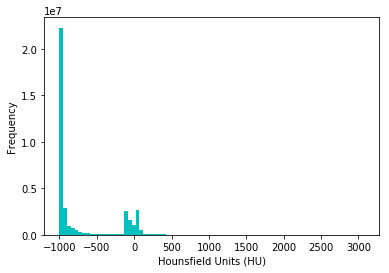

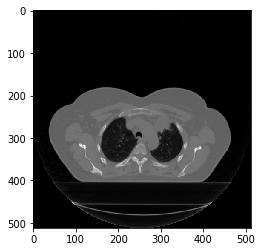

In [7]:
first_patient_ct, first_patient_rt = load_scan(INPUT_FOLDER + patients[0])

# Make a dictionary mapping the UID values of each slice to the slice number.
uid_location_dict = {}
for i, patient_slice in enumerate(first_patient_ct):
    uid_location_dict[patient_slice[0x0008, 0x0018].value] = i
                
# Construct a list of regions labeled in the RTst.
labeled_regions = [{"color": {}, "xs": [], "ys": [], "zs": []} for _ in xrange(len(first_patient_rt[0][0x3006, 0x0020].value))];

# Structure Set ROI Sequence is 3006.0020 in the RTst.
# http://dicom.nema.org/medical/Dicom/2016b/output/chtml/part03/sect_C.8.8.5.html
for i, ss_roi_sequence_i in enumerate(first_patient_rt[0][0x3006, 0x0020].value):
    print ("Found ROI: ", ss_roi_sequence_i[0x3006, 0x0026].value)

# ROI Contour Sequence is 3006.0039 in the Rtst
# http://dicom.nema.org/medical/dicom/2016c/output/chtml/part03/sect_C.8.8.6.html
for i, roi_contour_module_i in enumerate(first_patient_rt[0][0x3006, 0x0039].value):
    roi_number = i;
    roi_color = roi_contour_module_i[0x3006, 0x002A].value;
    contour_sequence = roi_contour_module_i[0x3006, 0x0040].value;
    labeled_regions[roi_number]["color"] = roi_color;
    for i, roi_contour_sequence_i in enumerate(contour_sequence):
        # Get the slice number corresponding to roi contour's Referenced SOP Instance UID
        sop_instance_uid = (roi_contour_sequence_i[0x3006,0x0016]).value[0][0x0008,0x1155].value;
        slice_number = uid_location_dict[sop_instance_uid];
        numPoints = roi_contour_sequence_i[0x3006, 0x0046].value;
        contour_type = roi_contour_sequence_i[0x3006, 0x0042].value;
        if contour_type != "CLOSED_PLANAR":
            print("Unsupported contour type found of type ", contour_type);
            exit();
        
        points = np.array(roi_contour_sequence_i[0x3006, 0x0050].value);
        points.shape = (numPoints, 3);
#         points = np.subtract(points, first_patient_ct[slice_number].ImagePositionPatient);
#         points = np.divide(points, (first_patient_ct[slice_number].PixelSpacing + [first_patient_ct[slice_number].SliceThickness]));
        zipped = zip(*points);
        labeled_regions[roi_number]["xs"].extend(np.subtract(zipped[0], first_patient_ct[slice_number].ImagePositionPatient[0]));
        labeled_regions[roi_number]["ys"].extend(zipped[1]);
        labeled_regions[roi_number]["zs"].extend(np.divide(zipped[2], first_patient_ct[slice_number].SliceThickness));

#print labeled_regions[roi_number]["dataPoints"];%%!

first_patient_pixels = get_pixels_hu(first_patient_ct)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [10]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel to mm ratio
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    # Get shape in mm
    new_real_shape = image.shape * spacing
    # Round to nearest integer
    new_shape = np.round(new_real_shape)
    # Get pixel to mm ratio after rounding
    real_resize_factor = new_shape / image.shape
    
    new_spacing = spacing / real_resize_factor
    
    start = time.time()
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    print("Time to zoom: ",(time.time() - start));
    
    return image, new_spacing

('Time to zoom: ', 32.894092082977295)
('Image shape before resampling\t', (144, 512, 512))
('Image shape after resampling\t', (360, 500, 500))


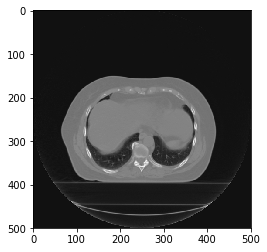

In [11]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient_ct, [1,1,1])

plt.imshow(pix_resampled[80], cmap=plt.cm.gray)
print("Image shape before resampling\t", first_patient_pixels.shape)
print("Image shape after resampling\t", pix_resampled.shape)

In [85]:
def plot_3d(image, labeled_regions, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
#     print labeled_regions[2]["zs"];
    region_points = [zip(labeled_regions[2]["zs"], labeled_regions[2]["ys"], labeled_regions[2]["xs"])]
    labeled_mesh = Poly3DCollection(region_points, alpha=0.1)
    labeled_mesh_color = [1, 0, 0]
    labeled_mesh.set_facecolor(labeled_mesh_color)
    ax.add_collection3d(labeled_mesh)
    
#     verts, faces = measure.marching_cubes(p, threshold)
#     body_mesh = Poly3DCollection(verts[faces], alpha=0.1)
#     body_mesh_color = [0, 0, 1]
#     body_mesh.set_facecolor(body_mesh_color)
#     ax.add_collection3d(body_mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

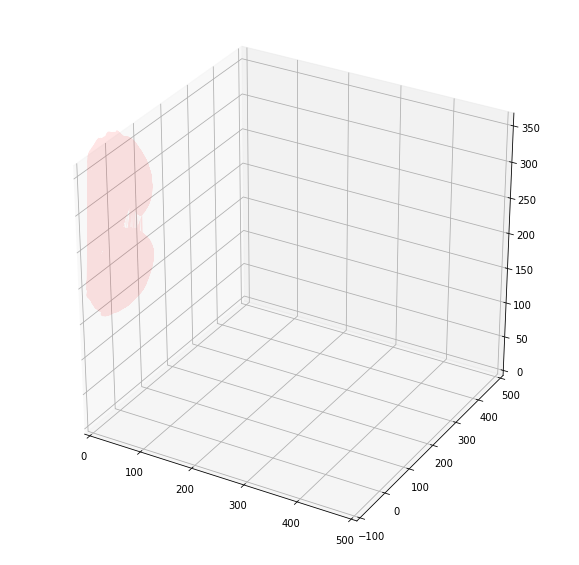

In [86]:
plot_3d(pix_resampled, labeled_regions, -350)

In [47]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [72]:
#np.array(pix_resampled > -320, dtype=np.int8)+1
segmented_lungs = segment_lung_mask(pix_resampled, False)
#segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

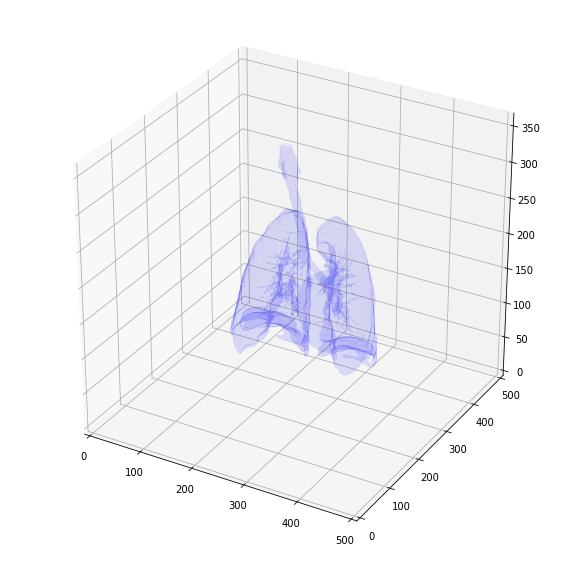

In [49]:
plot_3d(segmented_lungs, 0)

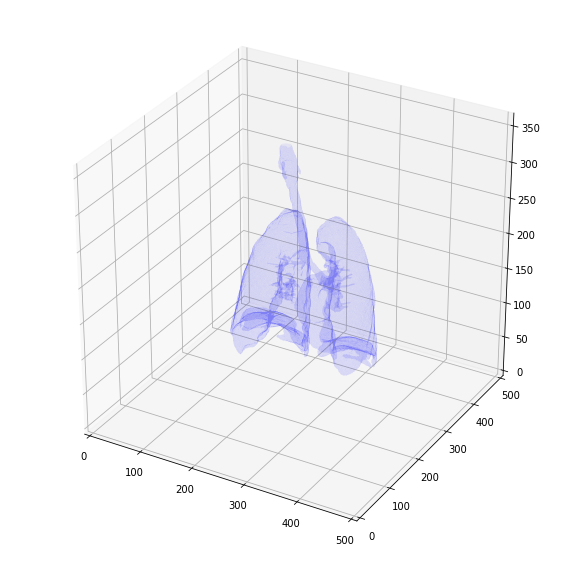

In [50]:
plot_3d(segmented_lungs_fill, 0)

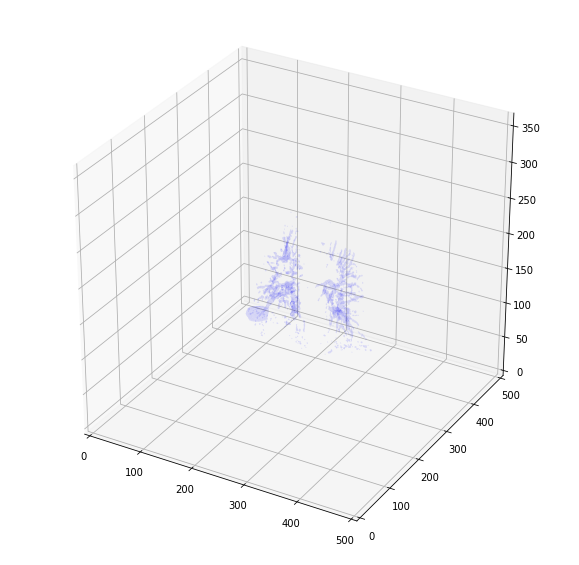

In [51]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)